# Clustering Crypto

In [1]:
# Initial imports
import pandas as pd
#import hvplot.plot
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines
import statistics
#import ffn

%pylab inline

%matplotlib inline

from pathlib import Path
from scipy import misc

Populating the interactive namespace from numpy and matplotlib


### Data Preprocessing

In [48]:
# Loade the cryptocurrencies data
file_path = Path("Resources/crypto_data.csv")
crypto_df = pd.read_csv(file_path, index_col=0)
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [49]:
# Keep only cryptocurrencies that are on trading
index = crypto_df[crypto_df['IsTrading'] == False].index

crypto_df.drop(index, inplace=True)

In [50]:
# Keep only cryptocurrencies with a working algorithm
crypto_df.isnull().sum()

CoinName             0
Algorithm            0
IsTrading            0
ProofType            0
TotalCoinsMined    459
TotalCoinSupply      0
dtype: int64

In [51]:
# Remove the "IsTrading" column
crypto_df.drop('IsTrading', axis = 1, inplace=True)

In [52]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)

In [53]:
# Remove rows with cryptocurrencies without coins mined
index_names = crypto_df[crypto_df['TotalCoinsMined'] == 0].index

crypto_df.drop(index_names, inplace=True)

In [54]:
# Fetch the cryptocurrencies names prior to drop them from crypto_df
coin_names = crypto_df['CoinName']

In [55]:
# Remove the cryptocurrency name since it's not going to be used on the clustering algorithm
crypto_df.drop('CoinName', axis = 1, inplace=True)

In [56]:
# Create dummies variables for text features
crypto_df_enc = crypto_df.copy()

crypto_df_enc = pd.get_dummies(
    crypto_df_enc, 
    columns=['Algorithm', 'ProofType'],
    drop_first=True
)

crypto_df_enc.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,Algorithm_Cloverhash,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# Standardize data
crypto_df_enc_scaled = StandardScaler().fit_transform(crypto_df_enc)

### Reducing Dimensions Using PCA

In [58]:
# Use PCA to reduce dimension to 3 principal components
pca = PCA(n_components=3)

crypto_pca = pca.fit_transform(crypto_df_enc_scaled)

In [59]:
# Create a DataFrame with the principal components data
crypto_pca_df = pd.DataFrame(
    data=crypto_pca, 
    columns=["PC1", "PC2", "PC3"],
    index=crypto_df.index
)

crypto_pca_df.head()

,PC1,PC2,PC3
42,-0.332707,1.024059,-0.559119
404,-0.316030,1.024383,-0.559464
1337,2.306147,1.749053,-0.589397
BTC,-0.146876,-1.301096,0.220228
ETH,-0.149676,-2.045098,0.378727


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

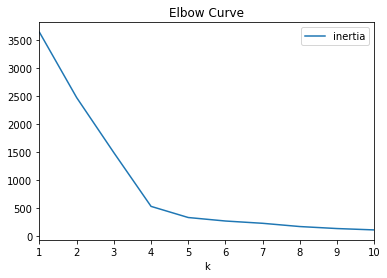

In [61]:
inertia = []
list_k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(crypto_pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": list_k, "inertia": inertia}

df_elbow = pd.DataFrame(elbow_data)

df_elbow.plot.line(x="k", y="inertia", xticks=list_k, title="Elbow Curve")

Running K-Means with `k=4`

In [64]:
# Initialize the K-Means model
model = KMeans(
    n_clusters=4,
    random_state=42
)

# Fit the model
model.fit(crypto_pca_df)
# Predict clusters
predictions = model.predict(crypto_pca_df)

# Add clusters column
crypto_pca_df["cluster"] = model.labels_

In [67]:
# Create a new DataFrame including predicted clusters and cryptocurrencies feature
crypto_cluster_df = pd.concat([crypto_df, crypto_pca_df], axis = 1)

crypto_cluster_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,cluster
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.332707,1.024059,-0.559119,1
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.316030,1.024383,-0.559464,1
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.306147,1.749053,-0.589397,1
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.146876,-1.301096,0.220228,0
ETH,Ethash,PoW,1.076842e+08,0,-0.149676,-2.045098,0.378727,0


### Visualizing Results

#### 3D-Scatter with Clusters

In [72]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    crypto_cluster_df,
    x="PC3",
    y="PC2",
    z="PC1",
    hover_name = coin_names,
    hover_data = ["Algorithm"],
    width=800,
)

fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [82]:
# Table with tradable cryptos
# Add coin names back
#crypto_cluster_df.insert(0, 'CoinName', coin_names)

# Table with tradable cryptos
#crypto_cluster_df.plot.table(columns=['CoinName', 'Algorithm', 'ProofType', 'TotalCoinSupply', 
                                 #'TotalCoinsMined','cluster'], width=800)

In [83]:
# Print the total number of tradable cryptocurrencies
print(f'There are {crypto_cluster_df.cluster.count()} tradable cryptos')

There are 533 tradable cryptos


#### Scatter Plot with Tradable Cryptocurrencies

In [43]:
# Scale data to create the scatter plot


In [86]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
#crypto_cluster_df.plot(kind='scatter', x = 'TotalCoinsMined', y = 'TotalCoinSupply')